## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

C:\Users\ladwi\anaconda3\envs\deeplearning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cuda:5


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("./../02_training/all_data_lake_modeling_in_time.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of          depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0            1     -1.260530      565.10046    -4.184752      -4.714701   
1            2     -1.260530      565.10046    -4.184752      -4.714701   
2            3     -1.260530      565.10046    -4.184752      -4.714701   
3            4     -1.260530      565.10046    -4.184752      -4.714701   
4            5     -1.260530      565.10046    -4.184752      -4.714701   
...        ...           ...            ...          ...            ...   
1752345     46     -3.080809      529.16738   -15.814628     -20.288304   
1752346     47     -3.080809      529.16738   -15.814628     -20.288304   
1752347     48     -3.080809      529.16738   -15.814628     -20.288304   
1752348     49     -3.080809      529.16738   -15.814628     -20.288304   
1752349     50     -3.080809      529.16738   -15.814628     -20.288304   

         Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  \
0   

In [5]:
training_frac = 0.60
depth_steps = 50
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 35047
Number of training points: 1051400


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [7]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_heat01']]

# Loading Models

In [8]:
m0_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 
                 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'temp_initial00']
m0_output_columns = ['temp_heat01']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./../02_training/saved_models/heating_model_time.pth"
m0_layers = [len(m0_input_columns), 32, 32, len(m0_output_columns)]

heating_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
heating_model.load_state_dict(m0_checkpoint)
heating_model = heating_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

In [9]:
m1_input_columns = ['depth', 'Area_m2', 'Uw',
                 'buoyancy', 'day_of_year', 'time_of_day',  'ice', 'snow', 'snowice','diffusivity', 'temp_total05']
m1_output_columns = ['temp_diff02']

m1_input_column_ix = [data_df.columns.get_loc(column) for column in m1_input_columns]
m1_output_column_ix = [data_df.columns.get_loc(column) for column in m1_output_columns]

m1_PATH = f"./../02_training/saved_models/diffusion_model_time.pth"
m1_layers = [len(m1_input_columns), 32, 32, len(m1_output_columns)]

heat_diff_model = MLP(m1_layers, activation="gelu")
m1_checkpoint = torch.load(m1_PATH, map_location=torch.device('cpu'))
heat_diff_model.load_state_dict(m1_checkpoint)
heat_diff_model = heat_diff_model.to(device)

Initializing Network with Xavier Initialization..


## Mixing Model

In [10]:
m2_input_columns = ['depth', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'day_of_year', 'time_of_day',
                   'ice', 'snow', 'snowice', 'temp_diff02']
m2_output_columns = ['temp_mix03']

m2_input_column_ix = [data_df.columns.get_loc(column) for column in m2_input_columns]
m2_output_column_ix = [data_df.columns.get_loc(column) for column in m2_output_columns]

m2_PATH = f"./../02_training/saved_models/mixing_model_time.pth"
m2_layers = [len(m2_input_columns), 32, 32, len(m2_output_columns)]

mixing_model = MLP(m2_layers, activation="gelu")
m2_checkpoint = torch.load(m2_PATH, map_location=torch.device('cpu'))
mixing_model.load_state_dict(m2_checkpoint)
mixing_model = mixing_model.to(device)

Initializing Network with Xavier Initialization..


# Convection Model

In [11]:
m3_input_columns = ['depth', 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'temp_diff02']
m3_output_columns = ['temp_conv04']

m3_input_column_ix = [data_df.columns.get_loc(column) for column in m3_input_columns]
m3_output_column_ix = [data_df.columns.get_loc(column) for column in m3_output_columns]

m3_PATH = f"./../02_training/saved_models/convection_model_time.pth"
m3_layers = [len(m3_input_columns), 32, 32, len(m3_output_columns)]

convection_model = MLP(m3_layers, activation="gelu")
m3_checkpoint = torch.load(m3_PATH, map_location=torch.device('cpu'))
convection_model.load_state_dict(m3_checkpoint)
convection_model = convection_model.to(device)

Initializing Network with Xavier Initialization..


# Ice Model

In [12]:
m4_input_columns = ['depth', 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice',
                   'temp_heat01']
m4_output_columns = ['temp_total05']

m4_input_column_ix = [data_df.columns.get_loc(column) for column in m4_input_columns]
m4_output_column_ix = [data_df.columns.get_loc(column) for column in m4_output_columns]

m4_PATH = f"./../02_training/saved_models/ice_model_time.pth"
m4_layers = [len(m4_input_columns), 32, 32, len(m4_output_columns)]

ice_model = MLP(m4_layers, activation="gelu")
m4_checkpoint = torch.load(m4_PATH, map_location=torch.device('cpu'))
ice_model.load_state_dict(m4_checkpoint)
ice_model = ice_model.to(device)

Initializing Network with Xavier Initialization..


In [13]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [14]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [15]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [16]:
# Create data set
batch_size = 1000

#assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [17]:
print(train_data.shape)
print(test_data.shape)

(1051400, 45)
(700950, 45)


In [18]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [19]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [20]:
def get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, loader, plot = True):    
    heating_model.eval()
    heat_diff_model.eval()
    mixing_model.eval()
    convection_model.eval()
    ice_model.eval()

    mean = torch.tensor(train_mean[m3_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m3_output_column_ix]).float().to(device)

    m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
    m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        #model 2
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m0_pred], dim=-1)

        m4_pred = ice_model(m4_input)

        
        #print(m1_pred)
        
        if plot:
            m4_y_true = x[:, m4_output_column_ix[0]] * torch.tensor(train_std[m4_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m4_output_column_ix[0]]).to(device)
            m4_y_pred = m4_pred * torch.tensor(train_std[m4_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m4_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 1] = rmse(m4_y_true.squeeze(), m4_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m1", rmse(m4_y_true.flatten(), m4_y_pred.flatten()))


        #model 3
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m4_pred], dim=-1)
        m1_pred = heat_diff_model(m1_input)
            
        if plot:
            m1_y_true = x[:, m1_output_column_ix] * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            m1_y_pred = m1_pred * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            rmse_models[ix, 3] = rmse(m1_y_true.squeeze(), m1_y_pred.squeeze())
            print("RMSE of after m3", rmse(m1_y_true.flatten(), m1_y_pred.flatten()))

        #model 4
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m1_pred], dim=-1)
        m3_pred = convection_model(m3_input)
            
        if plot:
            m3_y_true = x[:, m3_output_column_ix] * std + mean
            m3_y_pred = m3_pred * std + mean
            rmse_models[ix, 4] = rmse(m3_y_true.squeeze(), m3_y_pred.squeeze())
            print("RMSE of after m4", rmse(m3_y_true.flatten(), m3_y_pred.flatten()))

        y_true = x[:, m3_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m3_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [21]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='seismic', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='seismic', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

# Rollout Results

## Training Results

In [22]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0029124054
RMSE of after m1 0.009126661
RMSE of after m3 0.07234108
RMSE of after m4 0.07447791
RMSE of after m0 0.0036464115
RMSE of after m1 0.009455942
RMSE of after m3 0.058734693
RMSE of after m4 0.06436624
RMSE of after m0 0.0035301673
RMSE of after m1 0.010841894
RMSE of after m3 0.03433182
RMSE of after m4 0.03470232
RMSE of after m0 0.0040106755
RMSE of after m1 0.04675514
RMSE of after m3 0.09477414
RMSE of after m4 0.093382224
RMSE of after m0 0.0033642438
RMSE of after m1 0.024390971
RMSE of after m3 0.16425654
RMSE of after m4 0.16355911
RMSE of after m0 0.0030845655
RMSE of after m1 0.017461613
RMSE of after m3 0.10129647
RMSE of after m4 0.10082514
RMSE of after m0 0.0034197967
RMSE of after m1 0.0145096155
RMSE of after m3 0.04371126
RMSE of after m4 0.04261036
RMSE of after m0 0.0032689634
RMSE of after m1 0.012399365
RMSE of after m3 0.02122879
RMSE of after m4 0.020914
RMSE of after m0 0.0028790818
RMSE of after m1 0.011549167
RMSE of after m3 0.01

RMSE of after m1 0.018202843
RMSE of after m3 0.027941737
RMSE of after m4 0.03151918
RMSE of after m0 0.0038006273
RMSE of after m1 0.0123413885
RMSE of after m3 0.021787645
RMSE of after m4 0.025179723
RMSE of after m0 0.012454075
RMSE of after m1 0.022437885
RMSE of after m3 0.03399098
RMSE of after m4 0.039937306
RMSE of after m0 0.005166845
RMSE of after m1 0.014257569
RMSE of after m3 0.019092217
RMSE of after m4 0.022346271
RMSE of after m0 0.005930286
RMSE of after m1 0.012949952
RMSE of after m3 0.022085395
RMSE of after m4 0.023645703
RMSE of after m0 0.0046602115
RMSE of after m1 0.011751657
RMSE of after m3 0.02866786
RMSE of after m4 0.028420815
RMSE of after m0 0.004519751
RMSE of after m1 0.012210087
RMSE of after m3 0.016110886
RMSE of after m4 0.015672883
RMSE of after m0 0.0036132315
RMSE of after m1 0.00916998
RMSE of after m3 0.012702758
RMSE of after m4 0.013050511
RMSE of after m0 0.0028368088
RMSE of after m1 0.010901453
RMSE of after m3 0.013336157
RMSE of after

RMSE of after m0 0.0039493702
RMSE of after m1 0.006509115
RMSE of after m3 0.061493386
RMSE of after m4 0.06791787
RMSE of after m0 0.0031084574
RMSE of after m1 0.0056058196
RMSE of after m3 0.03799357
RMSE of after m4 0.0440704
RMSE of after m0 0.003081189
RMSE of after m1 0.005372839
RMSE of after m3 0.012839857
RMSE of after m4 0.016635101
RMSE of after m0 0.0051552127
RMSE of after m1 0.0060280454
RMSE of after m3 0.017301898
RMSE of after m4 0.021176295
RMSE of after m0 0.0042185234
RMSE of after m1 0.0061127455
RMSE of after m3 0.030744243
RMSE of after m4 0.038313888
RMSE of after m0 0.0042044185
RMSE of after m1 0.006149105
RMSE of after m3 0.014259402
RMSE of after m4 0.020499645
RMSE of after m0 0.0041253995
RMSE of after m1 0.006172031
RMSE of after m3 0.028402917
RMSE of after m4 0.02517466
RMSE of after m0 0.0046268073
RMSE of after m1 0.006450339
RMSE of after m3 0.017062843
RMSE of after m4 0.018095387
RMSE of after m0 0.013548838
RMSE of after m1 0.013988946
RMSE of a

RMSE of after m1 0.00927177
RMSE of after m3 0.035344444
RMSE of after m4 0.0335284
RMSE of after m0 0.004704389
RMSE of after m1 0.0072890464
RMSE of after m3 0.015678963
RMSE of after m4 0.017120905
RMSE of after m0 0.0062846183
RMSE of after m1 0.010636624
RMSE of after m3 0.0514153
RMSE of after m4 0.05224604
RMSE of after m0 0.0049495376
RMSE of after m1 0.0097647635
RMSE of after m3 0.030161275
RMSE of after m4 0.027856996
RMSE of after m0 0.003741119
RMSE of after m1 0.008496699
RMSE of after m3 0.01282208
RMSE of after m4 0.020208174
RMSE of after m0 0.0045780656
RMSE of after m1 0.008700987
RMSE of after m3 0.021128671
RMSE of after m4 0.019726446
RMSE of after m0 0.008196672
RMSE of after m1 0.009044877
RMSE of after m3 0.037020463
RMSE of after m4 0.03765859
RMSE of after m0 0.0071561676
RMSE of after m1 0.00928804
RMSE of after m3 0.023472415
RMSE of after m4 0.024572106
RMSE of after m0 0.0044763647
RMSE of after m1 0.008536275
RMSE of after m3 0.01253364
RMSE of after m4 

RMSE of after m1 0.007475438
RMSE of after m3 0.022223832
RMSE of after m4 0.026568187
RMSE of after m0 0.010979951
RMSE of after m1 0.009876596
RMSE of after m3 0.029050397
RMSE of after m4 0.029400643
RMSE of after m0 0.0075433673
RMSE of after m1 0.0072099743
RMSE of after m3 0.025861783
RMSE of after m4 0.026145192
RMSE of after m0 0.0054178205
RMSE of after m1 0.008598479
RMSE of after m3 0.07111416
RMSE of after m4 0.079294235
RMSE of after m0 0.00777518
RMSE of after m1 0.010539534
RMSE of after m3 0.05710761
RMSE of after m4 0.050497923
RMSE of after m0 0.0052329316
RMSE of after m1 0.00795736
RMSE of after m3 0.04135761
RMSE of after m4 0.036832355
RMSE of after m0 0.004374513
RMSE of after m1 0.0068674204
RMSE of after m3 0.048715174
RMSE of after m4 0.041989896
RMSE of after m0 0.004564112
RMSE of after m1 0.006549572
RMSE of after m3 0.037165437
RMSE of after m4 0.032270808
RMSE of after m0 0.005832103
RMSE of after m1 0.007354331
RMSE of after m3 0.037281238
RMSE of after 

RMSE of after m3 0.024221944
RMSE of after m4 0.022627639
RMSE of after m0 0.0067579728
RMSE of after m1 0.008871109
RMSE of after m3 0.016471837
RMSE of after m4 0.019164644
RMSE of after m0 0.014830021
RMSE of after m1 0.014873375
RMSE of after m3 0.018597633
RMSE of after m4 0.025896708
RMSE of after m0 0.010978683
RMSE of after m1 0.014849416
RMSE of after m3 0.015225462
RMSE of after m4 0.023934681
RMSE of after m0 0.008953965
RMSE of after m1 0.0137576265
RMSE of after m3 0.015030626
RMSE of after m4 0.022060968
RMSE of after m0 0.0030315465
RMSE of after m1 0.0098448135
RMSE of after m3 0.013273521
RMSE of after m4 0.022583101
RMSE of after m0 0.0028476645
RMSE of after m1 0.009329677
RMSE of after m3 0.012530062
RMSE of after m4 0.023589194
RMSE of after m0 0.0038304303
RMSE of after m1 0.009169968
RMSE of after m3 0.014314221
RMSE of after m4 0.027198453
RMSE of after m0 0.003565989
RMSE of after m1 0.007944572
RMSE of after m3 0.014260357
RMSE of after m4 0.02648928
RMSE of a

RMSE of after m4 0.017273502
RMSE of after m0 0.007736382
RMSE of after m1 0.011828015
RMSE of after m3 0.015355988
RMSE of after m4 0.017058585
RMSE of after m0 0.008416685
RMSE of after m1 0.012180957
RMSE of after m3 0.013354739
RMSE of after m4 0.013848414
RMSE of after m0 0.008077153
RMSE of after m1 0.011145354
RMSE of after m3 0.017708067
RMSE of after m4 0.018558867
RMSE of after m0 0.005961243
RMSE of after m1 0.011086681
RMSE of after m3 0.016617939
RMSE of after m4 0.018063353
RMSE of after m0 0.003150296
RMSE of after m1 0.013269477
RMSE of after m3 0.016903648
RMSE of after m4 0.01732501
RMSE of after m0 0.003569994
RMSE of after m1 0.011937941
RMSE of after m3 0.021511605
RMSE of after m4 0.021016572
RMSE of after m0 0.0035576622
RMSE of after m1 0.010650038
RMSE of after m3 0.019647675
RMSE of after m4 0.018207153
RMSE of after m0 0.003734002
RMSE of after m1 0.010563137
RMSE of after m3 0.014516761
RMSE of after m4 0.013920358
RMSE of after m0 0.0045664515
RMSE of after

RMSE of after m0 0.004056122
RMSE of after m1 0.007707095
RMSE of after m3 0.0153740505
RMSE of after m4 0.015230442
RMSE of after m0 0.0040175403
RMSE of after m1 0.007926442
RMSE of after m3 0.016107228
RMSE of after m4 0.0191759
RMSE of after m0 0.005404437
RMSE of after m1 0.007813875
RMSE of after m3 0.037294213
RMSE of after m4 0.040452275
RMSE of after m0 0.009740834
RMSE of after m1 0.010898344
RMSE of after m3 0.029055594
RMSE of after m4 0.027928468
RMSE of after m0 0.005202681
RMSE of after m1 0.007239954
RMSE of after m3 0.026077757
RMSE of after m4 0.030208116
RMSE of after m0 0.0058482494
RMSE of after m1 0.0081508085
RMSE of after m3 0.0190317
RMSE of after m4 0.022227153
RMSE of after m0 0.0054316805
RMSE of after m1 0.008070784
RMSE of after m3 0.029820114
RMSE of after m4 0.033685006
RMSE of after m0 0.004374899
RMSE of after m1 0.0076618707
RMSE of after m3 0.049210947
RMSE of after m4 0.04795978
RMSE of after m0 0.0037964846
RMSE of after m1 0.006796855
RMSE of afte

RMSE of after m4 0.023269895
RMSE of after m0 0.004624896
RMSE of after m1 0.009319387
RMSE of after m3 0.016530242
RMSE of after m4 0.018455042
RMSE of after m0 0.004939475
RMSE of after m1 0.00917468
RMSE of after m3 0.02529532
RMSE of after m4 0.023968875
RMSE of after m0 0.0068721953
RMSE of after m1 0.0092712855
RMSE of after m3 0.029269567
RMSE of after m4 0.025632322
RMSE of after m0 0.006658521
RMSE of after m1 0.008114775
RMSE of after m3 0.03989891
RMSE of after m4 0.03603722
RMSE of after m0 0.0047225696
RMSE of after m1 0.005895539
RMSE of after m3 0.011737214
RMSE of after m4 0.0118076615
RMSE of after m0 0.005881435
RMSE of after m1 0.008804266
RMSE of after m3 0.03477089
RMSE of after m4 0.03803071
RMSE of after m0 0.012987169
RMSE of after m1 0.017131072
RMSE of after m3 0.06830805
RMSE of after m4 0.061244085
RMSE of after m0 0.0062833847
RMSE of after m1 0.010607076
RMSE of after m3 0.054579236
RMSE of after m4 0.057614498
RMSE of after m0 0.005855979
RMSE of after m1

RMSE of after m0 0.004944076
RMSE of after m1 0.009714624
RMSE of after m3 0.021009497
RMSE of after m4 0.01954185
RMSE of after m0 0.0055014575
RMSE of after m1 0.009607394
RMSE of after m3 0.013229997
RMSE of after m4 0.017574009
RMSE of after m0 0.0050348938
RMSE of after m1 0.009669158
RMSE of after m3 0.017452098
RMSE of after m4 0.018416513
RMSE of after m0 0.0068277377
RMSE of after m1 0.00970861
RMSE of after m3 0.014722908
RMSE of after m4 0.016178498
RMSE of after m0 0.0053373147
RMSE of after m1 0.008323242
RMSE of after m3 0.028170329
RMSE of after m4 0.028933328
RMSE of after m0 0.0043363837
RMSE of after m1 0.0073537277
RMSE of after m3 0.027018843
RMSE of after m4 0.028096778
RMSE of after m0 0.0050200666
RMSE of after m1 0.010412974
RMSE of after m3 0.024235632
RMSE of after m4 0.02551323
RMSE of after m0 0.0061335275
RMSE of after m1 0.011229157
RMSE of after m3 0.04423439
RMSE of after m4 0.0395397
RMSE of after m0 0.0051824898
RMSE of after m1 0.0111785475
RMSE of af

RMSE of after m4 0.043184206
RMSE of after m0 0.0028165134
RMSE of after m1 0.013354867
RMSE of after m3 0.024619604
RMSE of after m4 0.03304252
RMSE of after m0 0.0028000926
RMSE of after m1 0.011093469
RMSE of after m3 0.023828793
RMSE of after m4 0.030982573
RMSE of after m0 0.002851255
RMSE of after m1 0.009170848
RMSE of after m3 0.016174406
RMSE of after m4 0.024189465
RMSE of after m0 0.0038668849
RMSE of after m1 0.011411855
RMSE of after m3 0.024370326
RMSE of after m4 0.030738581
RMSE of after m0 0.0064934082
RMSE of after m1 0.01898457
RMSE of after m3 0.02999453
RMSE of after m4 0.033852953
RMSE of after m0 0.0059780357
RMSE of after m1 0.008990287
RMSE of after m3 0.058759924
RMSE of after m4 0.04712909
RMSE of after m0 0.0037599823
RMSE of after m1 0.008434606
RMSE of after m3 0.042768814
RMSE of after m4 0.04576551
RMSE of after m0 0.005368965
RMSE of after m1 0.008396653
RMSE of after m3 0.047839686
RMSE of after m4 0.046030197
RMSE of after m0 0.005903182
RMSE of after

RMSE of after m4 0.016566074
RMSE of after m0 0.0032382768
RMSE of after m1 0.007209701
RMSE of after m3 0.013325652
RMSE of after m4 0.012458548
RMSE of after m0 0.010082927
RMSE of after m1 0.011482625
RMSE of after m3 0.022411115
RMSE of after m4 0.021860918
RMSE of after m0 0.0145674925
RMSE of after m1 0.010851172
RMSE of after m3 0.021639869
RMSE of after m4 0.020687994
RMSE of after m0 0.02022463
RMSE of after m1 0.0072500473
RMSE of after m3 0.017251713
RMSE of after m4 0.015450312
RMSE of after m0 0.016718417
RMSE of after m1 0.0064925053
RMSE of after m3 0.016039886
RMSE of after m4 0.015553939
RMSE of after m0 0.008584572
RMSE of after m1 0.0062265866
RMSE of after m3 0.014010953
RMSE of after m4 0.013551971
RMSE of after m0 0.007775691
RMSE of after m1 0.0062010335
RMSE of after m3 0.009375011
RMSE of after m4 0.009049766
RMSE of after m0 0.01262393
RMSE of after m1 0.007204279
RMSE of after m3 0.011599798
RMSE of after m4 0.011083524
RMSE of after m0 0.014466471
RMSE of af

RMSE of after m1 0.014476069
RMSE of after m3 0.016653238
RMSE of after m4 0.016209362
RMSE of after m0 0.004417257
RMSE of after m1 0.014145633
RMSE of after m3 0.015602624
RMSE of after m4 0.016158827
RMSE of after m0 0.0033486304
RMSE of after m1 0.01361201
RMSE of after m3 0.011343314
RMSE of after m4 0.012224605
RMSE of after m0 0.0032375017
RMSE of after m1 0.013978835
RMSE of after m3 0.013120495
RMSE of after m4 0.01455948
RMSE of after m0 0.0032788329
RMSE of after m1 0.01262525
RMSE of after m3 0.016665176
RMSE of after m4 0.016758086
RMSE of after m0 0.0033411526
RMSE of after m1 0.011127471
RMSE of after m3 0.012912483
RMSE of after m4 0.012651945
RMSE of after m0 0.0039027142
RMSE of after m1 0.008386526
RMSE of after m3 0.012636023
RMSE of after m4 0.013078788
RMSE of after m0 0.0034780998
RMSE of after m1 0.009283364
RMSE of after m3 0.0105979815
RMSE of after m4 0.010428396
RMSE of after m0 0.0037875068
RMSE of after m1 0.010248441
RMSE of after m3 0.012227872
RMSE of a

RMSE of after m1 0.006317424
RMSE of after m3 0.04148485
RMSE of after m4 0.036783516
RMSE of after m0 0.0030877122
RMSE of after m1 0.005548849
RMSE of after m3 0.022950357
RMSE of after m4 0.021256734
RMSE of after m0 0.0038320979
RMSE of after m1 0.00561945
RMSE of after m3 0.015300492
RMSE of after m4 0.017037235
RMSE of after m0 0.0038408367
RMSE of after m1 0.0052439715
RMSE of after m3 0.021012045
RMSE of after m4 0.021175664
RMSE of after m0 0.0050453064
RMSE of after m1 0.006065783
RMSE of after m3 0.0281399
RMSE of after m4 0.025971051
RMSE of after m0 0.0139611475
RMSE of after m1 0.014107094
RMSE of after m3 0.061078083
RMSE of after m4 0.055926617
RMSE of after m0 0.013678831
RMSE of after m1 0.01375202
RMSE of after m3 0.037433878
RMSE of after m4 0.033221748
Train RMSE Simulated: 0.038351938128471375
Train RMSE Observed Temp: 4.941962242126465
Train L2 Error: 0.005103901028633118
The RMSEs after each modelling stage: [0.00581493 0.01115322 0.         0.029158   0.0300511

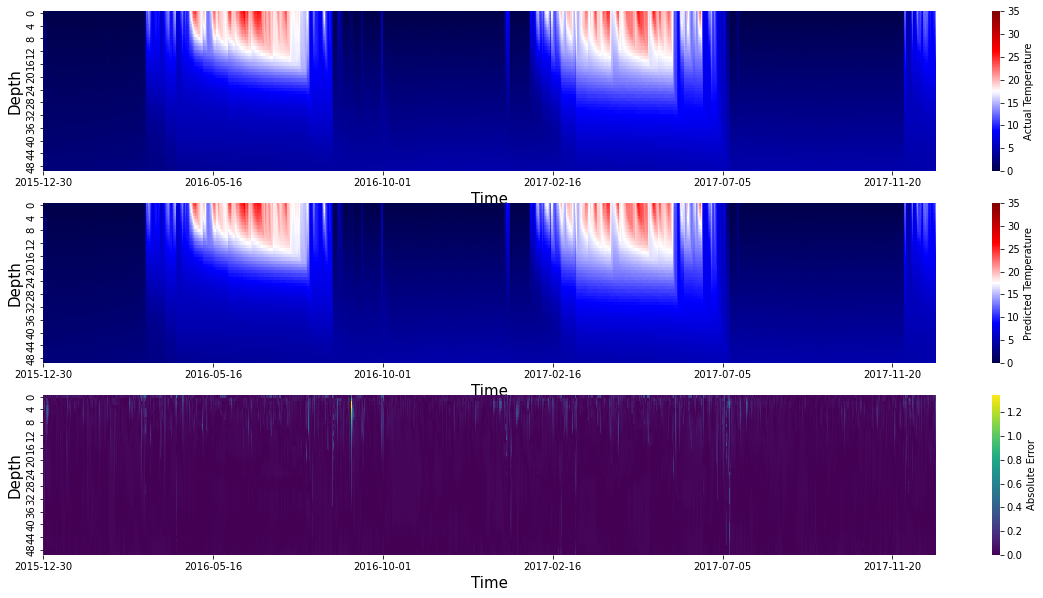

In [23]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

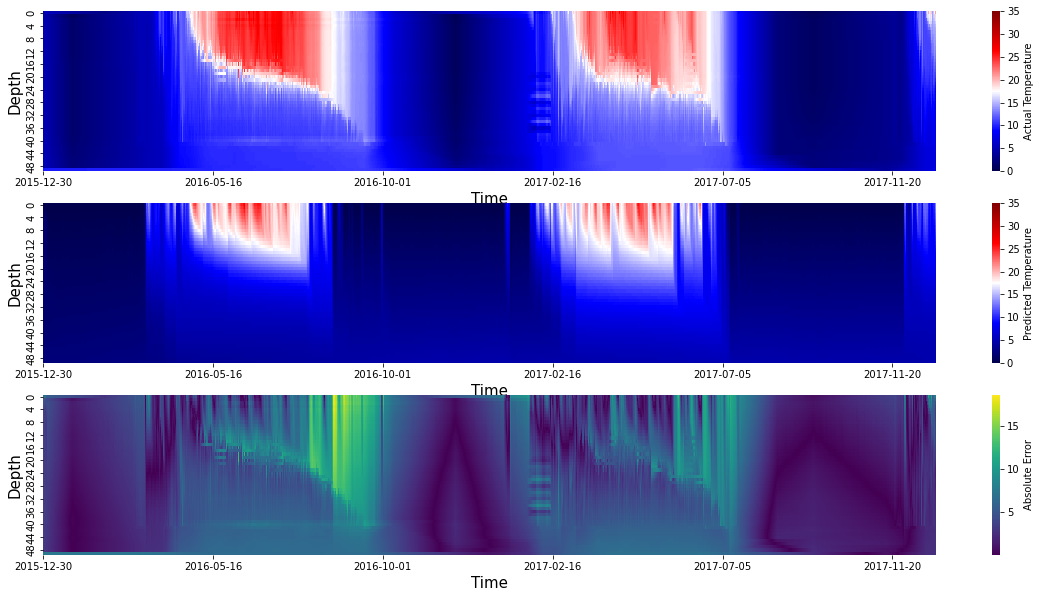

In [24]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [25]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model,heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0052546435
RMSE of after m1 0.005602804
RMSE of after m3 0.025516585
RMSE of after m4 0.029928945
RMSE of after m0 0.008140965
RMSE of after m1 0.010633476
RMSE of after m3 0.08881968
RMSE of after m4 0.09560594
RMSE of after m0 0.0053038998
RMSE of after m1 0.007857516
RMSE of after m3 0.030377299
RMSE of after m4 0.035542063
RMSE of after m0 0.0047248304
RMSE of after m1 0.0073852814
RMSE of after m3 0.028226428
RMSE of after m4 0.02913591
RMSE of after m0 0.0038077494
RMSE of after m1 0.0065797567
RMSE of after m3 0.04251161
RMSE of after m4 0.03885018
RMSE of after m0 0.010868557
RMSE of after m1 0.010779243
RMSE of after m3 0.057858605
RMSE of after m4 0.054087058
RMSE of after m0 0.0046290033
RMSE of after m1 0.005946589
RMSE of after m3 0.023856834
RMSE of after m4 0.032141156
RMSE of after m0 0.004211466
RMSE of after m1 0.006468765
RMSE of after m3 0.020124238
RMSE of after m4 0.02792241
RMSE of after m0 0.0040490655
RMSE of after m1 0.0068554827
RMSE of aft

RMSE of after m3 0.031781334
RMSE of after m4 0.026652997
RMSE of after m0 0.0071369736
RMSE of after m1 0.008578067
RMSE of after m3 0.014630704
RMSE of after m4 0.01630501
RMSE of after m0 0.0055068065
RMSE of after m1 0.007961029
RMSE of after m3 0.024067177
RMSE of after m4 0.023741797
RMSE of after m0 0.005972697
RMSE of after m1 0.010379611
RMSE of after m3 0.029540645
RMSE of after m4 0.029800048
RMSE of after m0 0.006002991
RMSE of after m1 0.010595307
RMSE of after m3 0.03788172
RMSE of after m4 0.033436447
RMSE of after m0 0.007045635
RMSE of after m1 0.011312977
RMSE of after m3 0.05028562
RMSE of after m4 0.049576808
RMSE of after m0 0.0045952536
RMSE of after m1 0.00830681
RMSE of after m3 0.023988927
RMSE of after m4 0.02836922
RMSE of after m0 0.0048996285
RMSE of after m1 0.008655362
RMSE of after m3 0.019219525
RMSE of after m4 0.022098197
RMSE of after m0 0.007286319
RMSE of after m1 0.012311041
RMSE of after m3 0.05107033
RMSE of after m4 0.044167563
RMSE of after m0

RMSE of after m1 0.007629638
RMSE of after m3 0.024700502
RMSE of after m4 0.018944502
RMSE of after m0 0.007488909
RMSE of after m1 0.007981187
RMSE of after m3 0.023673048
RMSE of after m4 0.026223602
RMSE of after m0 0.0091606425
RMSE of after m1 0.008415149
RMSE of after m3 0.028270194
RMSE of after m4 0.029456064
RMSE of after m0 0.0054453416
RMSE of after m1 0.0077750254
RMSE of after m3 0.054998763
RMSE of after m4 0.05754734
RMSE of after m0 0.007026873
RMSE of after m1 0.011819344
RMSE of after m3 0.045672163
RMSE of after m4 0.048980802
RMSE of after m0 0.0046443027
RMSE of after m1 0.009641812
RMSE of after m3 0.037340418
RMSE of after m4 0.031593286
RMSE of after m0 0.007104598
RMSE of after m1 0.01122299
RMSE of after m3 0.067389235
RMSE of after m4 0.05317781
RMSE of after m0 0.003637546
RMSE of after m1 0.007850366
RMSE of after m3 0.032203782
RMSE of after m4 0.030207332
RMSE of after m0 0.0030488807
RMSE of after m1 0.007338311
RMSE of after m3 0.01614313
RMSE of after

RMSE of after m1 0.04306699
RMSE of after m3 0.060992993
RMSE of after m4 0.057041824
RMSE of after m0 0.010862243
RMSE of after m1 0.03656627
RMSE of after m3 0.051000524
RMSE of after m4 0.049660254
RMSE of after m0 0.008496928
RMSE of after m1 0.03538443
RMSE of after m3 0.047436755
RMSE of after m4 0.046523847
RMSE of after m0 0.009738121
RMSE of after m1 0.036921162
RMSE of after m3 0.048348352
RMSE of after m4 0.046820406
RMSE of after m0 0.0070114597
RMSE of after m1 0.034135174
RMSE of after m3 0.042949833
RMSE of after m4 0.041395724
RMSE of after m0 0.005715868
RMSE of after m1 0.024455622
RMSE of after m3 0.032891057
RMSE of after m4 0.03319405
RMSE of after m0 0.0077503305
RMSE of after m1 0.023508336
RMSE of after m3 0.03224951
RMSE of after m4 0.03215094
RMSE of after m0 0.043280125
RMSE of after m1 0.038855247
RMSE of after m3 0.049515873
RMSE of after m4 0.045122568
RMSE of after m0 0.021264222
RMSE of after m1 0.028031949
RMSE of after m3 0.037319314
RMSE of after m4 0

RMSE of after m1 0.010556723
RMSE of after m3 0.014207649
RMSE of after m4 0.0152917765
RMSE of after m0 0.0066416394
RMSE of after m1 0.0130865695
RMSE of after m3 0.013670296
RMSE of after m4 0.015573499
RMSE of after m0 0.0057291626
RMSE of after m1 0.013081059
RMSE of after m3 0.016089689
RMSE of after m4 0.018673683
RMSE of after m0 0.0062355995
RMSE of after m1 0.021631595
RMSE of after m3 0.03378536
RMSE of after m4 0.03330779
RMSE of after m0 0.004715062
RMSE of after m1 0.012018627
RMSE of after m3 0.014950733
RMSE of after m4 0.01746604
RMSE of after m0 0.0032862579
RMSE of after m1 0.01259834
RMSE of after m3 0.014251864
RMSE of after m4 0.01740611
RMSE of after m0 0.0032977313
RMSE of after m1 0.012063808
RMSE of after m3 0.013062238
RMSE of after m4 0.015973167
RMSE of after m0 0.0044972897
RMSE of after m1 0.013281226
RMSE of after m3 0.010683253
RMSE of after m4 0.013006293
RMSE of after m0 0.006503823
RMSE of after m1 0.01210338
RMSE of after m3 0.011805759
RMSE of afte

RMSE of after m0 0.0036378074
RMSE of after m1 0.0045613428
RMSE of after m3 0.020923413
RMSE of after m4 0.019861097
RMSE of after m0 0.006103633
RMSE of after m1 0.007203476
RMSE of after m3 0.035556592
RMSE of after m4 0.031743575
RMSE of after m0 0.0043440545
RMSE of after m1 0.0058395723
RMSE of after m3 0.028594011
RMSE of after m4 0.03021065
RMSE of after m0 0.0037844705
RMSE of after m1 0.005915471
RMSE of after m3 0.017656354
RMSE of after m4 0.020493418
RMSE of after m0 0.004414505
RMSE of after m1 0.0067253537
RMSE of after m3 0.025945384
RMSE of after m4 0.026164196
RMSE of after m0 0.0037522349
RMSE of after m1 0.005961321
RMSE of after m3 0.026349295
RMSE of after m4 0.028784867
RMSE of after m0 0.002993509
RMSE of after m1 0.0049595875
RMSE of after m3 0.024966896
RMSE of after m4 0.02588671
RMSE of after m0 0.0037192942
RMSE of after m1 0.0061996575
RMSE of after m3 0.020809986
RMSE of after m4 0.0235205
RMSE of after m0 0.005607706
RMSE of after m1 0.007189884
RMSE of 

RMSE of after m1 0.008277515
RMSE of after m3 0.021209408
RMSE of after m4 0.03220616
RMSE of after m0 0.004989758
RMSE of after m1 0.008986763
RMSE of after m3 0.035342317
RMSE of after m4 0.04212516
RMSE of after m0 0.0046267766
RMSE of after m1 0.008557261
RMSE of after m3 0.01948849
RMSE of after m4 0.02696407
RMSE of after m0 0.0042465776
RMSE of after m1 0.007970747
RMSE of after m3 0.023572974
RMSE of after m4 0.026364775
RMSE of after m0 0.0041126446
RMSE of after m1 0.0075947023
RMSE of after m3 0.030805225
RMSE of after m4 0.038461827
RMSE of after m0 0.004604807
RMSE of after m1 0.0071875905
RMSE of after m3 0.018157352
RMSE of after m4 0.023681123
RMSE of after m0 0.008823013
RMSE of after m1 0.010579836
RMSE of after m3 0.026330195
RMSE of after m4 0.028075729
RMSE of after m0 0.0047696796
RMSE of after m1 0.009333287
RMSE of after m3 0.029652536
RMSE of after m4 0.03596069
RMSE of after m0 0.007596923
RMSE of after m1 0.011705842
RMSE of after m3 0.048941202
RMSE of after

RMSE of after m4 0.019137815
RMSE of after m0 0.0048388992
RMSE of after m1 0.008431027
RMSE of after m3 0.019755399
RMSE of after m4 0.022552889
RMSE of after m0 0.004961986
RMSE of after m1 0.009380041
RMSE of after m3 0.031602077
RMSE of after m4 0.029393569
RMSE of after m0 0.0042974954
RMSE of after m1 0.008738012
RMSE of after m3 0.027859898
RMSE of after m4 0.02326819
RMSE of after m0 0.0045016347
RMSE of after m1 0.008128173
RMSE of after m3 0.021551356
RMSE of after m4 0.01803555
RMSE of after m0 0.005501423
RMSE of after m1 0.009267527
RMSE of after m3 0.042572796
RMSE of after m4 0.04169278
RMSE of after m0 0.0050344886
RMSE of after m1 0.007408794
RMSE of after m3 0.025910107
RMSE of after m4 0.024281254
RMSE of after m0 0.00600985
RMSE of after m1 0.009610559
RMSE of after m3 0.034498617
RMSE of after m4 0.028976616
RMSE of after m0 0.0042039547
RMSE of after m1 0.008288825
RMSE of after m3 0.01646643
RMSE of after m4 0.020338172
RMSE of after m0 0.00505586
RMSE of after m

RMSE of after m0 0.004170253
RMSE of after m1 0.008609807
RMSE of after m3 0.06663146
RMSE of after m4 0.0667529
RMSE of after m0 0.006176824
RMSE of after m1 0.008848162
RMSE of after m3 0.06941414
RMSE of after m4 0.064305805
RMSE of after m0 0.0057312483
RMSE of after m1 0.008051057
RMSE of after m3 0.06526149
RMSE of after m4 0.053772885
RMSE of after m0 0.0030438036
RMSE of after m1 0.007953648
RMSE of after m3 0.053328358
RMSE of after m4 0.055268068
RMSE of after m0 0.0038128153
RMSE of after m1 0.008090391
RMSE of after m3 0.043141086
RMSE of after m4 0.045147285
RMSE of after m0 0.0043829693
RMSE of after m1 0.0080420375
RMSE of after m3 0.04732195
RMSE of after m4 0.046364855
RMSE of after m0 0.0036762014
RMSE of after m1 0.008289929
RMSE of after m3 0.026870307
RMSE of after m4 0.02388489
RMSE of after m0 0.0043316637
RMSE of after m1 0.009209626
RMSE of after m3 0.023272056
RMSE of after m4 0.021079887
RMSE of after m0 0.004124444
RMSE of after m1 0.0092937285
RMSE of after

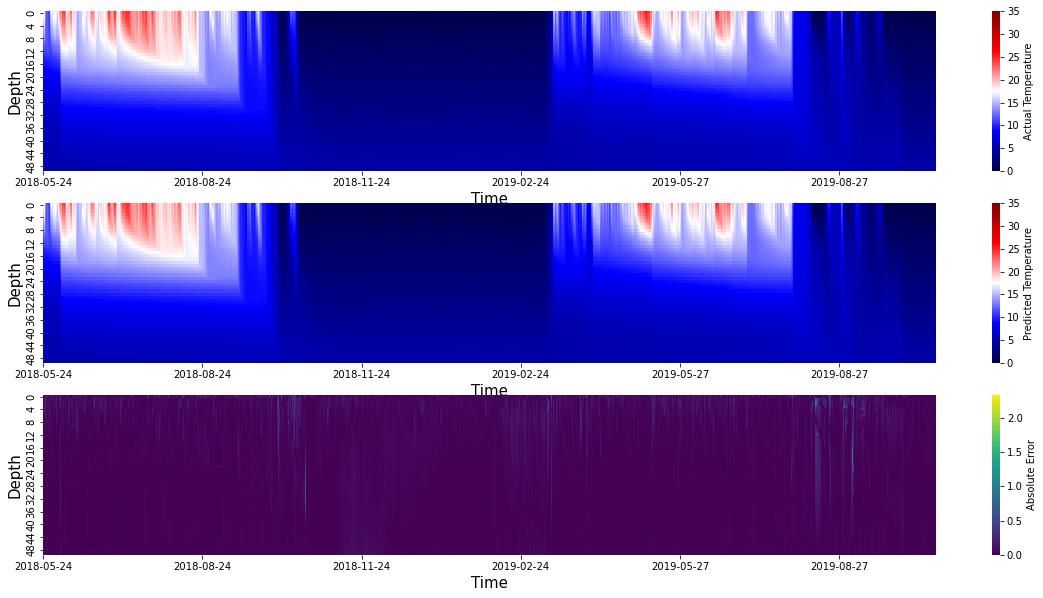

In [26]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

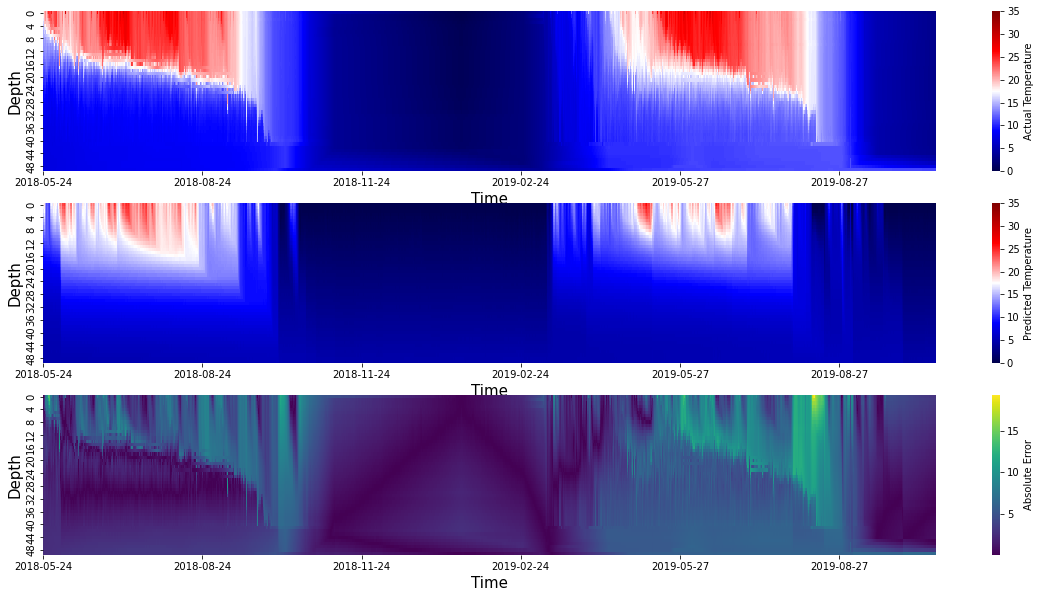

In [27]:
plot_output(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [28]:
train_rmse, train_l2_err = compute_metrics( heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.03877625100228446, Train L2 Error: 0.005162898149671834
Test RMSE: 0.04634656786640357, Train L2 Error: 0.005419512337509612


## Mixing Model

## Convection Model

In [29]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.018310529549497186, Train L2 Error: 0.0024381173011145847
Test RMSE: 0.02039795069652996, Train L2 Error: 0.0023853682454973964


## Ice Model

In [30]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.01196459434775981, Train L2 Error: 0.0015920655184288295
Test RMSE: 0.018364006047621506, Train L2 Error: 0.002146076087011106


# Finetuning

In [31]:
lr = 1e-5
# decay_rate = 0.1
# decay_steps = 500

params = list(heating_model.parameters()) + list(heat_diff_model.parameters()) + list(convection_model.parameters()) + list(ice_model.parameters())

optimizer = torch.optim.Adam(params, lr=lr, 
                             betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

# Freeze model weights

In [32]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [33]:
#freeze_model(heating_model)
freeze_model(heating_model)
unfreeze_model(heat_diff_model)
freeze_model(convection_model)
freeze_model(ice_model)


# Finetuning on Observed Temperature

In [ ]:
heating_model.train()
heat_diff_model.train()
convection_model.train()
ice_model.train()

n_epochs = 1000

# mean and standard dev of "temp_total04" of model 4 output
mean_out3 = torch.tensor(train_mean[m3_output_column_ix[0]]).float().to(device)
std_out3 = torch.tensor(train_std[m3_output_column_ix[0]]).float().to(device)

mean_obs = torch.tensor(train_mean[obs_temp_columns_ix[0]]).float().to(device)
std_obs = torch.tensor(train_std[obs_temp_columns_ix[0]]).float().to(device)

# mean and standard dev of "input_temp" of model 1 input
m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

train_loss = []
LOSS_m0 = []
LOSS_m1 = []
LOSS_m2 = []
LOSS_m3 = []
LOSS_m4 = []

for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    loss_epoch_m0 = 0
    loss_epoch_m1 = 0
    loss_epoch_m2 = 0
    loss_epoch_m3 = 0
    loss_epoch_m4 = 0
    for ix, x in enumerate(iter(train_loader)):
        x = x.to(device).float()
        optimizer.zero_grad()
        
      #  m1_input = x[:, m1_input_column_ix]
        m0_input = x[:, m0_input_column_ix]
        
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
        loss_m0 = criterion(m0_pred, x[:, m0_output_column_ix])

        #model 1
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m0_pred], dim=-1)
        # m1_pred = heat_diff_model(m1_input)
        
        m4_pred = ice_model(m4_input)
        loss_m4 = criterion(m4_pred, x[:, m4_output_column_ix])
        
        #m1_pred = heat_diff_model(m1_input) #predicts diff and temp
        #m1_pred_temp = m1_pred[:,1:2]
            
        #loss_m1 = criterion(m1_pred_temp, x[:, m1_output_column_ix[1]].unsqueeze(1))

        #model 3
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m4_pred], dim=-1)
        m1_pred = heat_diff_model(m1_input)

        loss_m1 = criterion(m1_pred, x[:, m1_output_column_ix])

        #model 4
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m1_pred], dim=-1)
        m3_pred = convection_model(m3_input)
        
        obs_temp_true = x[:, obs_temp_columns_ix] * std_obs + mean_obs
        obs_temp_true_norm = (obs_temp_true - mean_out3)/std_out3
        
        loss_m3 = criterion(m3_pred, obs_temp_true_norm)

        #loss = (loss_m0 + loss_m1 + loss_m2 + loss_m3 + loss_m4)
        
        loss = loss_m3
        
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
        loss_epoch_m0 += loss_m0.item()
        loss_epoch_m1 += loss_m1.item()
        loss_epoch_m3 += loss_m3.item()
        loss_epoch_m4 += loss_m4.item()
    
    loss_epoch = loss_epoch/len(train_loader)
    loss_epoch_m0 = loss_epoch_m0/len(train_loader)
    loss_epoch_m1 = loss_epoch_m1/len(train_loader)
    loss_epoch_m3 = loss_epoch_m3/len(train_loader)
    loss_epoch_m4 = loss_epoch_m4/len(train_loader)
    
    train_loss.append(loss_epoch)
    LOSS_m0.append(loss_epoch_m0)
    LOSS_m1.append(loss_epoch_m1)
    LOSS_m3.append(loss_epoch_m3)
    LOSS_m4.append(loss_epoch_m4)
    if it % 50 == 0:
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Loss m0: {LOSS_m0[-1]}, Loss m1: {LOSS_m1[-1]},  Loss m3: {LOSS_m3[-1]}, Loss m4: {LOSS_m4[-1]}")
    
    #plot the loss_m1, m2


  0%|          | 1/1000 [00:08<2:27:37,  8.87s/it]

Epoch : 0, Train_loss: 0.8596257007434723, Loss m0: 1.7746708053755615e-06, Loss m1: 0.004465237570414453,  Loss m3: 0.8596257007434723, Loss m4: 6.179620070760801e-06


  5%|▌         | 51/1000 [08:06<2:30:15,  9.50s/it]

Epoch : 50, Train_loss: 0.1304750492218209, Loss m0: 1.7746708053755615e-06, Loss m1: 0.7979285726890308,  Loss m3: 0.1304750492218209, Loss m4: 6.179620070760801e-06


 10%|█         | 101/1000 [15:50<1:51:06,  7.42s/it]

Epoch : 100, Train_loss: 0.11197145356369088, Loss m0: 1.7746708053755615e-06, Loss m1: 0.8276288118638353,  Loss m3: 0.11197145356369088, Loss m4: 6.179620070760801e-06


 15%|█▌        | 151/1000 [21:58<1:38:25,  6.96s/it]

Epoch : 150, Train_loss: 0.10104780143360119, Loss m0: 1.7746708053755615e-06, Loss m1: 0.8390908138755666,  Loss m3: 0.10104780143360119, Loss m4: 6.179620070760801e-06


 20%|██        | 201/1000 [27:42<1:31:31,  6.87s/it]

Epoch : 200, Train_loss: 0.09234480813848113, Loss m0: 1.7746708053755615e-06, Loss m1: 0.8470813078458771,  Loss m3: 0.09234480813848113, Loss m4: 6.179620070760801e-06


 25%|██▌       | 251/1000 [33:27<1:24:35,  6.78s/it]

Epoch : 250, Train_loss: 0.08440606897770332, Loss m0: 1.7746708053755615e-06, Loss m1: 0.8531609747519879,  Loss m3: 0.08440606897770332, Loss m4: 6.179620070760801e-06


 30%|███       | 301/1000 [39:13<1:18:48,  6.76s/it]

Epoch : 300, Train_loss: 0.07701617612825713, Loss m0: 1.7746708053755615e-06, Loss m1: 0.8585761622702809,  Loss m3: 0.07701617612825713, Loss m4: 6.179620070760801e-06


 35%|███▌      | 351/1000 [45:00<1:15:35,  6.99s/it]

Epoch : 350, Train_loss: 0.07072085717351251, Loss m0: 1.7746708053755615e-06, Loss m1: 0.8644254385801776,  Loss m3: 0.07072085717351251, Loss m4: 6.179620070760801e-06


 40%|████      | 401/1000 [50:51<1:09:55,  7.00s/it]

Epoch : 400, Train_loss: 0.06578789906400989, Loss m0: 1.7746708053755615e-06, Loss m1: 0.8704090107483754,  Loss m3: 0.06578789906400989, Loss m4: 6.179620070760801e-06


 45%|████▌     | 451/1000 [56:40<1:03:53,  6.98s/it]

Epoch : 450, Train_loss: 0.061982495031238115, Loss m0: 1.7746708053755615e-06, Loss m1: 0.8759281540523237,  Loss m3: 0.061982495031238115, Loss m4: 6.179620070760801e-06


 50%|█████     | 501/1000 [1:02:33<57:57,  6.97s/it]  

Epoch : 500, Train_loss: 0.058974309137202585, Loss m0: 1.7746708053755615e-06, Loss m1: 0.8806564139623634,  Loss m3: 0.058974309137202585, Loss m4: 6.179620070760801e-06


 55%|█████▌    | 551/1000 [1:08:24<52:20,  7.00s/it]

Epoch : 550, Train_loss: 0.056501116989044996, Loss m0: 1.7746708053755615e-06, Loss m1: 0.8846065760537019,  Loss m3: 0.056501116989044996, Loss m4: 6.179620070760801e-06


 60%|██████    | 601/1000 [1:14:12<46:19,  6.97s/it]

Epoch : 600, Train_loss: 0.05438805562285786, Loss m0: 1.7746708053755615e-06, Loss m1: 0.8879432152361811,  Loss m3: 0.05438805562285786, Loss m4: 6.179620070760801e-06


 65%|██████▌   | 651/1000 [1:20:05<40:33,  6.97s/it]

Epoch : 650, Train_loss: 0.05252124528297021, Loss m0: 1.7746708053755615e-06, Loss m1: 0.8908195378269448,  Loss m3: 0.05252124528297021, Loss m4: 6.179620070760801e-06


 70%|███████   | 701/1000 [1:25:55<34:50,  6.99s/it]

Epoch : 700, Train_loss: 0.05083004715483939, Loss m0: 1.7746708053755615e-06, Loss m1: 0.8933566472344384,  Loss m3: 0.05083004715483939, Loss m4: 6.179620070760801e-06


 74%|███████▍  | 740/1000 [1:30:29<30:17,  6.99s/it]

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label = "Train Loss")
plt.plot(LOSS_m0, label = "Loss M0")
plt.plot(LOSS_m1, label = "Loss M1")
#plt.plot(LOSS_m2, label = "Loss M2")
plt.plot(LOSS_m3, label = "Loss M3")
plt.plot(LOSS_m4, label = "Loss M4")
plt.ylabel("Loss", fontsize=15)
plt.xlabel("Epoch", fontsize=15)
plt.yscale("log")
plt.legend(fontsize=15)
plt.show()

# Rollout Evaluation After FineTuning

In [ ]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

In [ ]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

In [ ]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

In [ ]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

In [ ]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

In [ ]:
plot_output(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [ ]:
train_rmse, train_l2_err = compute_metrics(heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

## Mixing Model

## Convection Model

In [ ]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

## Ice Model

In [ ]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

# Compute Model Similarity after Finetuning

In [ ]:
def compute_model_similarity(model1, model2):
    weight1 = []
    weight2 = []
    for param1, param2 in zip(model1.parameters(), model2.parameters()):
        weight1.append(param1.detach().clone().flatten())
        weight2.append(param2.detach().clone().flatten())
    weight1 = torch.cat(weight1, dim=0)
    weight2 = torch.cat(weight2, dim=0)
    
    #Cosine Similarity
    cos = nn.CosineSimilarity(dim=0, eps=1e-8)
    cos_sim = cos(weight1, weight2)
    
    #L2 norm
    l2 = torch.norm((weight1-weight2), p='fro', dim=0)
    
    return cos_sim, l2

In [ ]:
heating_model_init = MLP(m0_layers, activation="gelu")
heating_model_init.load_state_dict(m0_checkpoint)
heating_model_init = heating_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heating_model_init, heating_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

In [ ]:
heat_diff_model_init = MLP(m1_layers, activation="gelu")
heat_diff_model_init.load_state_dict(m1_checkpoint)
heat_diff_model_init = heat_diff_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heat_diff_model_init, heat_diff_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

In [ ]:
convection_model_init = MLP(m3_layers, activation="gelu")
convection_model_init.load_state_dict(m3_checkpoint)
convection_model_init = convection_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(convection_model_init, convection_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

In [ ]:
ice_model_init = MLP(m4_layers, activation="gelu")
ice_model_init.load_state_dict(m4_checkpoint)
ice_model_init = ice_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(ice_model_init, ice_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

In [ ]:
# Freeze all models again and compute finetuned diffusivity values

In [ ]:
# Unfreeze diffusion model and finetune it on projected diffusivities

In [ ]:
PATH = f"./saved_models/diffusion_model_finetuned.pth"
torch.save(heat_diff_model.state_dict(), PATH)

In [ ]:
def plot_output_freeLimits(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='seismic')
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='seismic')
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

In [ ]:
plot_output_freeLimits(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

In [ ]:
plot_output_freeLimits(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(20,10))